## Trabajo Fin de Grado
### Gestor de Quirófanos
### Implementación de Algoritmo Genético para asignación de quirófanos

#### Autor: Jesús García Armario

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import sys
sys.path.append('../')
from Heuristicas.Utils import Quirofano, ActoQuirurgico
import random
import math
import matplotlib.pyplot as plt

In [2]:
# Importamos el listado preprocesado de una especialidad para las pruebas
filename = '..\\..\\Datos\\Listados_Preprocesados\\ListadoInterv_Preprocesado_MAXILOFACIAL.xlsx'
df = pd.read_excel(filename)
# Seleccionamos una muestra aleatoria de 100 pacientes
df = df.sample(n=100, random_state=1)
# Nos quedamos sólo con el NHC, Ponderación y duración
df = df[['NHC', 'PONDERACIÓN', 'DURACIÓN']]
# Creamos un set de actos quirúrgicos
actos_pendientes = list()
i = 0
for elemento in df.itertuples():
    actos_pendientes.append(ActoQuirurgico(i, elemento[3], elemento[1], elemento[2]))
    i += 1

In [3]:
# Definimos un cromosoma como una lista de tamaño N
# donde N es el número de slots temporales disponibles
# El ID de la operación ocupará la posición del slot temporal o 0 si no se ha asignado
# El cromosoma se codifica como una lista de enteros
# Con separadores representados por caracteres especiales, siendo 'A' el separador de quirófanos
# y 'B' el separador de días
def cromosomaAleatorio(tiempos, quirofanos, dias, actos_pendientes):
    actos = actos_pendientes.copy()
    cromosoma = []
    # Generamos un cromosoma aleatorio
    for i in range(dias):
        for j in range(quirofanos):
            # Seleccionamos un numero de intervenciones aleatorio para el slot
            num_intervenciones = random.randint(1, tiempos)
            if num_intervenciones > len(actos):
                num_intervenciones = len(actos)
            # Seleccionamos las intervenciones aleatorias
            intervenciones = random.choices(actos, k= num_intervenciones)
            # Las añadimos al cromosoma
            for intervencion in intervenciones:
                cromosoma.append(intervencion.getId())
            actos = [acto for acto in actos if acto not in intervenciones]
            # Añadimos un separador de quirófanos
            cromosoma.append('A')
        # Añadimos un separador de días
        cromosoma.append('B')
    return cromosoma

In [4]:
# Definimos al individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("cromosoma", cromosomaAleatorio, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.cromosoma)
toolbox.register("poblacion", tools.initRepeat, list, toolbox.individual)

In [5]:
# Variables globales
# Definimos la función de fitness
def evaluar(individual, tiempos, quirofanos, dias, actos_pendientes,ventana):
    if not validar(individual, tiempos, quirofanos, dias, actos_pendientes,ventana):
        return -100*distance(individual, tiempos, ventana, actos_pendientes),
    # Calculamos el fitness como la suma de las ponderaciones de los actos quirúrgicos
    fitness = 0
    tiempo_quirofano = 0
    # Calculamos el fitness
    for i in range(len(individual)):
        if individual[i] != 'A' and individual[i] != 'B':
            fitness += actos_pendientes[individual[i]].getPrioridad()
            tiempo_quirofano += actos_pendientes[individual[i]].getDuracion()
    # Calculamos el tiempo de uso de quirófano
    tiempo_quirofano = tiempo_quirofano / (quirofanos * dias)
    return fitness*tiempo_quirofano,

# Definimos la función de validez
def validar(individual, tiempos, quirofanos, dias, actos_pendientes,ventana):
    # Comprobamos que la duración de las intervenciones no supera el tiempo disponible
    tiempo_quirofano = 0
    for elemento in individual:
        if elemento == 'A' or elemento == 'B':
            tiempo_quirofano = 0
            continue
        tiempo_quirofano += math.ceil(actos_pendientes[elemento].getDuracion() / ventana)
        if tiempo_quirofano > tiempos:
            return False
    return True

def distance(individual,tiempos,ventana,actos_pendientes):
    # Calculamos la distancia entre los actos quirúrgicos
    dist = 0
    tiempo_quirofano = 0
    for elemento in individual:
        if elemento == 'A' or elemento == 'B':
            tiempo_quirofano = 0
            continue
        tiempo_quirofano += math.ceil(actos_pendientes[elemento].getDuracion() / ventana)
        if tiempo_quirofano > tiempos:
            dist += (tiempo_quirofano - tiempos)**2
    return dist


In [6]:
def cruce(ind1, ind2):
    # Obtenemos una copia de los padres
    hijo1 = ind1.copy()
    hijo2 = ind2.copy()
    padre1 = ind1.copy()
    padre2 = ind2.copy()
    # Eliminamos los separadores de los padres
    padre1 = [i for i in ind1 if i!='A' and i!='B']
    padre2 = [i for i in ind2 if i!='A' and i!='B']
    # Selecccionamos dos puntos de cruces aleatorios
    punto1 = random.randint(0, len(ind1)-1)
    while ind1[punto1] == 'A' and ind1[punto1] == 'B':
        punto1 = random.randint(0, len(ind1)-1)
    punto2 = random.randint(0, len(ind1)-1)
    while ind1[punto2] == 'A' and ind1[punto2] == 'B' and punto2 == punto1:
        punto2 = random.randint(0, len(ind1)-1)
    punto3 = random.randint(0, len(ind2)-1)
    while ind2[punto3] == 'A' and ind2[punto3] == 'B':
        punto3 = random.randint(0, len(ind2)-1)
    punto4 = random.randint(0, len(ind2)-1)
    while ind2[punto4] == 'A' and ind2[punto4] == 'B' and punto4 == punto3:
        punto4 = random.randint(0, len(ind2)-1)
    # Añadimos los genes del padre 2 al hijo 1 hasta la región de cruce
    if punto1>punto2:
        punto = punto1
        punto1 = punto2
        punto2 = punto
    if punto3>punto4:
        punto = punto3
        punto3 = punto4
        punto4 = punto
    for i in range(len(hijo1)):
        if i < punto1 or i > punto2:
            if hijo1[i] == 'A' or hijo1[i] == 'B':
                continue
            elif len(padre2) == 0:
                break
            hijo1[i] = padre2.pop(0)
    # Añadimos los genes del padre 1 al hijo 2 hasta la región de cruce
    for i in range(len(hijo2)):
        if i < punto3 or i > punto4:
            if hijo2[i] == 'A' or hijo2[i] == 'B':
                continue
            elif len(padre1) == 0:
                break
            hijo2[i] = padre1.pop(0)
    return hijo1, hijo2
def mutacion(individual):
    # Calculamos los índices posibles de intercambio
    indices = [i for i in range(len(individual)) if individual[i] != 'A' and individual[i] != 'B']
    # Seleccionamos dos índices aleatorios
    indices = random.choices(indices, k=2)
    # Intercambiamos los valores
    individual[indices[0]], individual[indices[1]] = individual[indices[1]], individual[indices[0]]
    return individual

In [7]:
toolbox.register("evaluate", evaluar, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes,ventana=30)
toolbox.register("mate", cruce)
toolbox.register("mutate", mutacion)
toolbox.register("select", tools.selRoulette)

Mejor individuo:  [49, 81, 7, 41, 'A', 83, 26, 74, 21, 87, 35, 55, 91, 'A', 52, 'A', 'B', 36, 32, 'A', 34, 71, 'A', 96, 48, 15, 27, 64, 62, 23, 93, 75, 88, 'A', 'B', 14, 20, 'A', 3, 73, 95, 97, 'A', 66, 54, 94, 'A', 'B', 5, 45, 2, 13, 65, 1, 47, 90, 16, 13, 72, 'A', 40, 51, 13, 56, 84, 77, 46, 19, 61, 79, 61, 38, 84, 22, 99, 10, 'A', 53, 60, 76, 37, 28, 89, 59, 30, 43, 92, 57, 69, 58, 11, 'A', 'B', 42, 64, 70, 44, 82, 25, 68, 39, 9, 80, 86, 29, 29, 31, 78, 'A', 50, 8, 17, 62, 24, 67, 0, 33, 4, 6, 54, 'A', 68, 85, 63, 98, 'A', 'B']
Mejor fitness:  -574200.0
Fitness medio:  -574910.0
Peor fitness:  -580200.0


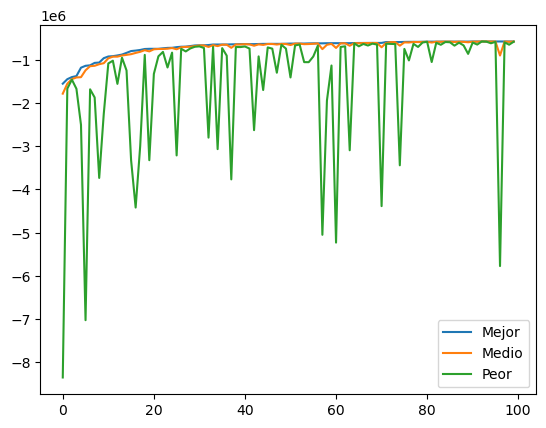

In [8]:
# Definimos los parámetros del algoritmo
# Tamaño de la población
tPoblacion = 100
# Probabilidad de cruce
pCruce = 0.8
# Probabilidad de mutación
pMutacion = 0.2
# Número de generaciones
nGeneraciones = 100
# Creamos la población inicial
poblacion = toolbox.poblacion(n=tPoblacion)
# Evaluamos la población inicial
fitnesses = list(map(toolbox.evaluate, poblacion))
for ind, fit in zip(poblacion, fitnesses):
    ind.fitness.values = fit
# Hoffman
hof = tools.HallOfFame(1)
# Guardamos el mejor individuo
hof.update(poblacion)
mejor = hof[0]
# Guardamos el mejor fitness
mejorFitness = mejor.fitness.values[0]
# Guardamos el fitness medio
fitnessMedio = 0
# Guardamos el fitness del peor individuo
peorFitness = 0
# Guardamos el fitness del mejor individuo de cada generación
mejoresFitness = []
# Guardamos el fitness medio de cada generación
fitnessesMedios = []
# Guardamos el fitness del peor individuo de cada generación
peoresFitness = []
# Guardamos el número de generaciones sin mejora
nGeneracionesSinMejora = 0
# Ejecutamos el algoritmo
for i in range(nGeneraciones):
    hof = tools.HallOfFame(1)
    # Seleccionamos la siguiente generación
    offspring = toolbox.select(poblacion, len(poblacion))
    # Clonamos los individuos seleccionados
    offspring = list(map(toolbox.clone, offspring))
    # Aplicamos el cruce
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < pCruce:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    # Aplicamos la mutación
    for mutant in offspring:
        if random.random() < pMutacion:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    # Evaluamos los individuos con fitness inválido
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    # Reemplazamos la población por la nueva generación
    poblacion[:] = offspring
    hof.update(poblacion)
    if len(hof) > 0:
        mejor = hof[0]
    # Guardamos el mejor fitness
    mejorFitness = max(mejorFitness, mejor.fitness.values[0])
    # Guardamos el fitness medio
    fitnessMedio = sum([ind.fitness.values[0] for ind in poblacion])/len(poblacion)
    # Guardamos el fitness del peor individuo
    peorFitness = min([ind.fitness.values[0] for ind in poblacion])
    # Guardamos el fitness del mejor individuo de cada generación
    mejoresFitness.append(mejorFitness)
    # Guardamos el fitness medio de cada generación
    fitnessesMedios.append(fitnessMedio)
    # Guardamos el fitness del peor individuo de cada generación
    peoresFitness.append(peorFitness)
    # Si el mejor individuo no ha mejorado, incrementamos el contador
    if len(mejoresFitness)>=2 and mejorFitness == mejoresFitness[-2]:
        nGeneracionesSinMejora += 1
    else:
        nGeneracionesSinMejora = 0
    # Si no ha habido mejora en las últimas 50 generaciones, paramos
    if nGeneracionesSinMejora == 50:
        break

# Mostramos los resultados
print("Mejor individuo: ", mejor)
print("Mejor fitness: ", mejorFitness)
print("Fitness medio: ", fitnessMedio)
print("Peor fitness: ", peorFitness)
# Mostramos la gráfica
plt.plot(mejoresFitness, label="Mejor")
plt.plot(fitnessesMedios, label="Medio")
plt.plot(peoresFitness, label="Peor")
plt.legend()
plt.show()